In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from core import med_log_odds_cutoff

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6


In [4]:
predictions = pd.read_parquet('../data3/processed/refseq_1k_predictions.pq')
predictions['assembly_stub'] = predictions['assembly'].str.split('.', expand=True)[0]

In [5]:
defense_finder_1o_genes = pd.read_parquet('../data/interim/defense_finder_genes_genomes.pq')

In [6]:
df_2o_hits = pd.read_csv('../data3/external/refseq1k_df2_0.csv')
df_2o_hits['assembly_stub'] = df_2o_hits['replicon'].str.split('.', expand=True)[0]
df_2o_hits['system'] = df_2o_hits['gene_name'].str.split('__', expand=True)[0]

In [7]:
unique_df_2o_df = (df_2o_hits.groupby('sys_id')
                   .head(1)
                   .reset_index(drop=True))
unique_df_2o_df['DS'] = unique_df_2o_df['type'].str.startswith('DS-')

In [8]:
unique_df_2o_df['DS'].sum()/len(unique_df_2o_df)

0.026770538243626064

In [9]:
non_rm_crispr_2o_systems = unique_df_2o_df[(unique_df_2o_df['type'] != 'RM') & 
                                           (unique_df_2o_df['type'] != 'CAS')]


In [10]:
non_rm_crispr_2o_systems['DS'].sum()/len(non_rm_crispr_2o_systems)

0.038197251414713015

In [11]:
(df_2o_hits['type'].value_counts()/len(df_2o_hits)).head(10)

type
RM             0.262291
Cas            0.228930
Wadjet         0.041667
BREX           0.033090
CBASS          0.020529
Lamassu-Fam    0.018571
Gabija         0.016005
Septu          0.015262
AbiE           0.014114
Ceres          0.012763
Name: count, dtype: float64

In [12]:
merged_predictions = (predictions
                      .merge(df_2o_hits.rename(columns={'hit_id': 'product_accession', 
                                                        'gene_name': 'defense_system_gene_2o',
                                                        'sys_id': 'sys_id_2o', 
                                                        'type': 'type_2o', 
                                                        'subtype': 'subtype_2o'})
                             [['assembly_stub', 'product_accession', 'defense_system_gene_2o', 
                               'sys_id_2o', 'type_2o', 'subtype_2o']], how='left', 
                             on=['assembly_stub', 'product_accession']))


In [13]:
defense_finder_1o_systems = pd.read_table('https://raw.githubusercontent.com/mdmparis/defense-finder-models/ed035a9869b820302e30e16b6651239596e8195f/DefenseFinder_rules.tsv')['System']

In [14]:
df2o_novel = (merged_predictions[merged_predictions['defense_system_gene'].isna() & 
                                 ~merged_predictions['defense_system_gene_2o'].isna() & 
                                 ~merged_predictions['type_2o'].isin(defense_finder_1o_systems) & 
                                 ~(merged_predictions['type_2o'] == 'Paris') &
                                 ~merged_predictions['subtype_2o'].str.contains('DS-', na=False)])

In [44]:
df2o_novel

,protein_context_id,mean_log_odds,sd_log_odds,min_log_odds,max_log_odds,# feature,class,assembly,assembly_unit,seq_type,...,defense_system_gene,defense_system,defense_system_protein,seq,seq_id,cluster_id,defense_system_gene_2o,sys_id_2o,type_2o,subtype_2o
8236,WP_219347468.1|NZ_CP079896.1|1459243|-,-11.703366,2.576774,-14.531417,-6.914575,CDS,with_protein,GCF_019355955.1,Primary Assembly,chromosome,...,None,None,False,MKMNVTETVKQACGHWPRILPALGVPVIKNRHQACPVCGGSDRFRF...,5ed5a451c30c22920d675628025559272ece3d69c90881...,9ebe54c54cfd3dfe906d5611f42d3c85a13c3c3e9b6d02...,SDIC3__SDIC3F,GCF_019355955.1_ASM1935595v1_protein_SDIC3_4,SDIC3,SDIC3
8237,WP_219347469.1|NZ_CP079896.1|1461591|-,-6.188995,2.048986,-8.102334,-2.217931,CDS,with_protein,GCF_019355955.1,Primary Assembly,chromosome,...,None,None,False,MKKPLPPVLRAALYRRAVACAWLTLCERQHRYPQLTLDALERAIAA...,5858bc38c884ed4d02fe04402fdbce8f865879137f5d73...,42e7d9aa54c00daf9f083e8dfff639c6d0a4c34568af18...,SDIC3__SDIC3E,GCF_019355955.1_ASM1935595v1_protein_SDIC3_4,SDIC3,SDIC3
8238,WP_219347470.1|NZ_CP079896.1|1461908|-,-8.293100,1.016621,-9.576647,-6.655952,CDS,with_protein,GCF_019355955.1,Primary Assembly,chromosome,...,None,None,False,MKHPAITLKDLECLEHLRNVGQLVSDLSQAQDSTTLCHSPAQRLQL...,13997084c03143c03bdae86d10596d091309dee3192942...,dd2be02b42a75fad6b05c45035c7564d9e8f39a168853c...,SDIC3__SDIC3D,GCF_019355955.1_ASM1935595v1_protein_SDIC3_4,SDIC3,SDIC3
8239,WP_219347471.1|NZ_CP079896.1|1462132|-,-12.251493,1.002965,-13.750993,-10.695986,CDS,with_protein,GCF_019355955.1,Primary Assembly,chromosome,...,None,None,False,MMMAVLLKAPFSGLLLFAVSRYSFPAVAKSAAGICSPCNSMATPDA...,db2ead86eb747e11bc9b638dcdc1e680d7c3096cb27bb2...,4f70b28e679007baeb10549a5564cd3f918d86b3f21f65...,SDIC3__SDIC3C,GCF_019355955.1_ASM1935595v1_protein_SDIC3_4,SDIC3,SDIC3
13035,WP_103370700.1|NZ_VEML01000001.1|1163054|-,-9.188145,1.723677,-12.301799,-7.079121,CDS,with_protein,GCF_007682245.1,Primary Assembly,unplaced scaffold,...,None,None,False,MITVLFGGSRPEGNTATLTKQALEGVEHTWIDLTEYRFDPVRDVRH...,45e8ecc26f0293d884499982b25e3d4ee2f8d00c0724f1...,2cb2557c51ba5dcb7b9833f4de70248700f98299e8580e...,gcu233__gcu233,GCF_007682245.1_ASM768224v1_protein_gcu233_3,gcu233,gcu233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3968203,WP_232306766.1|NZ_KQ950184.1|220543|-,-7.023752,1.544631,-9.554573,-4.706683,CDS,with_protein,GCF_001517975.1,Primary Assembly,unplaced scaffold,...,None,None,False,MSSPLPPTPEQARMAMVDAMAAERARLGAQPLPRAVEEALRAVPRE...,fa7046d774e858c69f46b4d7ec3cb8f3b01914922b5d28...,19db73d50154f7e1c318ec08abb48f7a10715327b6f0b6...,Lanthiphage__LphE,GCF_001517975.1_ASM151797v1_protein_Lanthiphage_5,Lanthiphage,Lanthiphage
3968283,WP_269745543.1|NZ_KQ950182.1|194540|+,-6.829181,1.664767,-8.846016,-4.391825,CDS,with_protein,GCF_001517975.1,Primary Assembly,unplaced scaffold,...,None,None,False,MWASDGFAASVEIASPDLARRVQEVCQGSRVRRQEVRRAVLSLIRY...,2b23ba0717aca67eac4ec6159ccd0a13a722a5c5c25627...,fc38d271121134acf3183d49d264a10127cd4988cd888e...,Lanthiphage__LphB1,GCF_001517975.1_ASM151797v1_protein_Lanthiphage_6,Lanthiphage,Lanthiphage
3968284,WP_269745544.1|NZ_KQ950182.1|197617|+,-6.789651,1.337720,-8.363409,-4.376243,CDS,with_protein,GCF_001517975.1,Primary Assembly,unplaced scaffold,...,None,None,False,MAGGAAGIALLHIERAYTGHGDWTTVHTWLSAAVHEELSAGPNAGL...,65d8c36ea65dcfdfaec80aed5f99e69b18b77768092370...,125ddf222e9d6733c4ae643a3cdc2c7be5e42affb6a769...,Lanthiphage__LphC,GCF_001517975.1_ASM151797v1_protein_Lanthiphage_6,Lanthiphage,Lanthiphage
3968686,WP_009853500.1|NZ_CP054015.1|1217640|-,10.458209,0.767217,9.387387,11.656488,CDS,with_protein,GCF_013267695.1,Primary Assembly,chromosome,...,None,None,False,MINIDAQFIDTISQILSDYISHSEITRMGEVLGYPQNDQDSGLNKH...,19f23607d235144862318f6a1b65e65d13c8a42feefccb...,b802610e4580d72594bd200309d11787d2f47f45b4953e...,VP1853__VP1853,GCF_013267695.1_ASM1326769v1_protein_VP1853_3,VP1853,VP1853


In [46]:
agg_df2o_novel = (df2o_novel.groupby(['sys_id_2o', 'type_2o', 'subtype_2o'])
                  .agg(n_genes = ('defense_system_gene_2o', 'nunique'), 
                       max_prediction = ('mean_log_odds', 'max'),
                       min_prediction = ('mean_log_odds', 'min'))
                  .reset_index())

In [52]:
pred_defensive_multigene_novel = (agg_df2o_novel[(agg_df2o_novel['max_prediction'] > 0) & 
                                                 (agg_df2o_novel['n_genes'] > 1)])

In [56]:
print('# Multigene systems: ', len(pred_defensive_multigene_novel))
print('# systems with all predicted defensive', (pred_defensive_multigene_novel['min_prediction'] > 0).sum())

# Multigene systems:  122
# systems with all predicted defensive 95


In [53]:
pred_defensive_multigene_novel['subtype_2o'].value_counts()

subtype_2o
HEC-01                   15
Hma                      13
CoCoNut_I-B              11
6A_MBL                   11
TgvAB                    10
HEC-03                    7
HEC-02                    7
GAPS4                     5
TIR-III                   5
CoCoNut_II                4
Detocs                    4
MADS                      3
CoCoNut_III-A             2
Lanthiphage               2
UG36                      2
AspAB                     2
Butters_gp30_gp31         2
Sucellos                  2
JukAB                     2
FS_HsdR_like              2
UG17                      1
CARD_NLR_like             1
UG34                      1
UG6                       1
UG25                      1
CARD_NLR_Endonuclease     1
CoCoNut_III-B             1
Detocs_hydrolase          1
CARD_NLR_Subtilase        1
Eleos                     1
UG19_small                1
Name: count, dtype: int64

In [15]:
novel_systems = df2o_novel['type_2o'].unique()

In [16]:
novel_systems

array(['SDIC3', 'gcu233', 'FS_Sma', 'AbiAlpha', 'MazEF', 'HEC-03',
       'HEC-01', 'Damona', 'HEC-06', 'Ceres', 'Sirona', 'All_UG',
       'Prometheus', 'HEC-09', 'Belisama', 'GAPS2', 'HEC-05', 'MADS',
       'Oshun', 'Prithvi', 'GAPS1', 'VP1851', 'Esos', '6A_MBL', 'Hypnos',
       'gcu24', 'VP1826', 'CoCoNut', 'Lanthiphage', 'Hna', 'VP1853',
       'Nantosuelta', 'GAPS4', 'AspAB', 'Detocs', 'TIR-III', 'VP1840',
       'TgvAB', 'Ukko', 'Erebus', 'JukAB', 'Ogmios', 'Charlie_gp32',
       'Divona', 'HEC-02', 'Taranis', 'CARD_NLR', 'Sucellos', 'HEC-07',
       'Toutatis', 'Eleos', 'VP1839', 'Hma', 'Panchino_gp28', 'HEC-08',
       'FS_GIY_YIG', 'Butters_gp30_gp31', 'gcu76', 'FS_HP', 'VP1817',
       'Cernunnos', 'FS_HsdR_like', 'HEC-04', 'gcu142', 'Tha', 'gcuWGS21',
       'Butters_gp57r', 'Nemetona'], dtype=object)

In [17]:
len(novel_systems)

68

In [18]:
merged_predictions['novel_system'] = merged_predictions['type_2o'].isin(novel_systems)

In [19]:
def assign_defense_label(row):
    if row['novel_system']:
        return "Defensive,\ndeposited after training"
    elif row['defense_system_gene']:
        return "Defensive,\ndeposited before training"
    else:
        return "Non-defesnive"

In [20]:
merged_predictions['defense_label'] = merged_predictions.apply(assign_defense_label, axis=1)
merged_predictions['defense_label'] = pd.Categorical(merged_predictions['defense_label'], 
                                                    categories=["Defensive,\ndeposited after training", 
                                                                "Defensive,\ndeposited before training", 
                                                                "Non-defesnive"])

In [21]:
merged_predictions.query("novel_system")['sys_id_2o'].nunique()

1178

In [22]:
cluster_predictions = (merged_predictions.sort_values('mean_log_odds', ascending=False)
                       .groupby('cluster_id')
                       .head(1))

In [58]:
cluster_predictions.query('novel_system')['subtype_2o'].nunique()

100

In [23]:
cluster_predictions['defense_label'].value_counts()

defense_label
Non-defesnive                            736602
Defensive,\ndeposited before training      3738
Defensive,\ndeposited after training        469
Name: count, dtype: int64

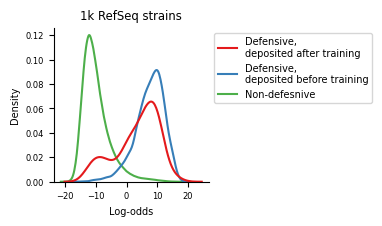

In [24]:
_, ax = plt.subplots(figsize=(2,2))
sns.kdeplot(data=cluster_predictions, x='mean_log_odds', hue='defense_label', common_norm=False, 
            palette='Set1')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title=None)
plt.title('1k RefSeq strains')
plt.xlabel('Log-odds')
sns.despine()
plt.savefig('../figures/dp_df_2o_dist.svg', dpi=300, bbox_inches='tight')

In [25]:
top_df2o_novel = (df2o_novel.sort_values('mean_log_odds', ascending=False)
                  .groupby('defense_system_gene_2o')
                  .head(1))

<Axes: xlabel='mean_log_odds', ylabel='Count'>

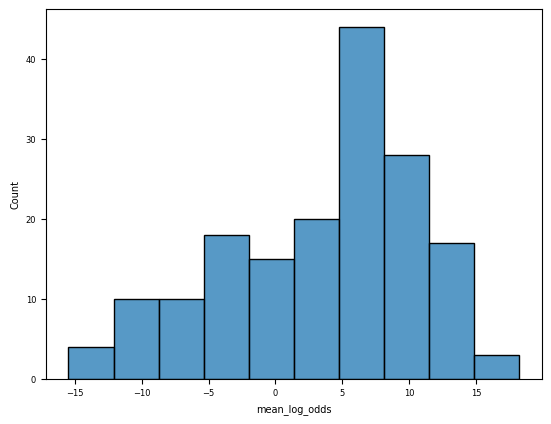

In [26]:
sns.histplot(data=top_df2o_novel, 
             x='mean_log_odds')

In [27]:
len(top_df2o_novel)

169

In [28]:
(top_df2o_novel['mean_log_odds'] > 0).mean()

0.7041420118343196

In [29]:
(top_df2o_novel['mean_log_odds'] > med_log_odds_cutoff).mean()

0.5562130177514792

In [30]:
top_df2o_novel[top_df2o_novel['type_2o'] == 'Lanthiphage']

,protein_context_id,mean_log_odds,sd_log_odds,min_log_odds,max_log_odds,# feature,class,assembly,assembly_unit,seq_type,...,defense_system_gene,defense_system,defense_system_protein,seq,seq_id,cluster_id,defense_system_gene_2o,sys_id_2o,type_2o,subtype_2o
1282864,WP_017574965.1|NZ_ANAY01000006.1|26454|+,2.561107,0.432813,2.024181,3.115398,CDS,with_protein,GCF_000340965.1,Primary Assembly,unplaced scaffold,...,None,None,False,MNQDRWFPLVPRKRPPAEPIGTRVERILRDAQLAHEGNGQEAANGL...,a9a4c09191a0d7ea4ca404eb4dbb237d2a959bf80facf7...,f5fb51c118f2436dc5d49182ecef09c02be1c7ed24a3ab...,Lanthiphage__LphF,GCF_000340965.1_SOAPdenovo_v1.06_protein_Lanth...,Lanthiphage,Lanthiphage
1969419,WP_204031374.1|NZ_BOOW01000044.1|37385|-,0.282600,0.553431,-0.386165,0.875669,CDS,with_protein,GCF_016863435.1,Primary Assembly,unplaced scaffold,...,None,None,False,MKASDHQPWLQIDVDFADPSTAEHNTIVYLVPALRSAEESGLISSW...,982b9493eb1567b671f019ebc904989d1e0c4ce1b1ec84...,5ae833a2272ad50d74a2780c24ef75975efdca488332fc...,Lanthiphage__LphD,GCF_016863435.1_ASM1686343v1_protein_Lanthipha...,Lanthiphage,Lanthiphage
1282863,WP_017574964.1|NZ_ANAY01000006.1|24433|+,-2.434050,0.890324,-3.233387,-0.753590,CDS,with_protein,GCF_000340965.1,Primary Assembly,unplaced scaffold,...,None,None,False,MQHDDHPQVLIEWAHWPQAEQGGQTLLSALDQHGAASDLTRWWFLR...,55446a2ea3c9f3012ed8e9edad9f1c610163da0bc20f88...,8c63404c9dcd366c58759019b0cd56ceeeeff2f016cb4f...,Lanthiphage__LphDE,GCF_000340965.1_SOAPdenovo_v1.06_protein_Lanth...,Lanthiphage,Lanthiphage
3496867,WP_091082795.1|NZ_FMHT01000003.1|3740985|+,-4.034460,1.454597,-6.434203,-2.256146,CDS,with_protein,GCF_900091585.1,Primary Assembly,unplaced scaffold,...,None,None,False,MTAGQSLADGAAGIALLHLETGNRPAAYEALRQATAGGVSIAEGAS...,1d8c27d2fb2e4ac6c6851dc4dcd9b3749e3717f71496ed...,125ddf222e9d6733c4ae643a3cdc2c7be5e42affb6a769...,Lanthiphage__LphC,GCF_900091585.1_IMG-taxon_2619619644_annotated...,Lanthiphage,Lanthiphage
3531606,WP_089100619.1|NZ_BCFL01000017.1|1003967|+,-4.066816,1.793784,-7.519246,-2.535334,CDS,with_protein,GCF_002217755.1,Primary Assembly,unplaced scaffold,...,None,None,False,MNTTTGASPEDLRNRLVDAILQQDVSGPRDARVETAMRTVPRHAFL...,679736a79a8f77f18f0cd2e661239b7da7ce1f0067bd53...,5e89182200496a85254551c244782d731d8fc8301edd36...,Lanthiphage__LphE,GCF_002217755.1_ASM221775v1_protein_Lanthiphage_2,Lanthiphage,Lanthiphage
3702586,WP_199880907.1|NZ_JUJA01000068.1|6946|-,-4.196318,0.760716,-5.289669,-3.429964,CDS,with_protein,GCF_001906585.1,Primary Assembly,unplaced scaffold,...,None,None,False,ATVVDPTGSLPPALQEDARSSSAAPDLRLDATVRLPTAVLTEAQTA...,96459bcbb1c370b82857fb659321f17b6538d79e541414...,96459bcbb1c370b82857fb659321f17b6538d79e541414...,Lanthiphage__LphB3,GCF_001906585.1_ASM190658v1_protein_Lanthiphage_5,Lanthiphage,Lanthiphage
1969420,WP_204031376.1|NZ_BOOW01000044.1|39413|-,-6.223381,0.817306,-7.190288,-5.063590,CDS,with_protein,GCF_016863435.1,Primary Assembly,unplaced scaffold,...,None,None,False,MVGTEQLRFDSVDAAIIRVAALDSPHTIPPWPDLIGSRPAQVDEWR...,20d9722029c188f632a429b7a3166639fada68b8cf3766...,fc38d271121134acf3183d49d264a10127cd4988cd888e...,Lanthiphage__LphB1,GCF_016863435.1_ASM1686343v1_protein_Lanthipha...,Lanthiphage,Lanthiphage
3525827,WP_188124431.1|NZ_BOMP01000141.1|45992|+,-6.373807,1.351038,-8.854992,-4.763181,CDS,with_protein,GCF_016862255.1,Primary Assembly,unplaced scaffold,...,None,None,False,MPIAHHRYHLVGPVLVRASTFPEHPLPPPPDPTATIEQAWAWLAAA...,c2d225f05e693f5cdad8e2507f2c7a20a5b7bf88e82f96...,82d2da7e96cbf788668c5d94d70f327be6db14284804fd...,Lanthiphage__LphB4,GCF_016862255.1_ASM1686225v1_protein_Lanthipha...,Lanthiphage,Lanthiphage
3496866,WP_091082793.1|NZ_FMHT01000003.1|3738241|+,-6.900818,0.850828,-8.035774,-5.755963,CDS,with_protein,GCF_900091585.1,Primary Assembly,unplaced scaffold,...,None,None,False,MVPAAGAALIRIAAYPKCLVLSPWPDIAGGHPDQWREWLDTTWTLP...,021ab589a4d8a76dc544db7b0d28b4ce8e31ff9e300d4b...,fc38d271121134acf3183d49d264a10127cd4988cd888e...,Lanthiphage__LphB2,GCF_900091585.1_IMG-taxon_2619619644_annotated...,L

In [31]:
top_sys_predictions = (top_df2o_novel.sort_values('mean_log_odds', ascending=False)
                       .groupby('subtype_2o')
                       .head(1))

In [32]:
(top_sys_predictions['mean_log_odds'] > 0).mean()

0.82

In [33]:
(top_sys_predictions['mean_log_odds'] > med_log_odds_cutoff).mean()

0.68

In [34]:
len(top_sys_predictions)

100

In [35]:
med_log_odds_cutoff

4

In [36]:
top_sys_predictions['type_2o'].value_counts()

type_2o
All_UG           24
CoCoNut           7
CARD_NLR          3
Detocs            2
AspAB             1
                 ..
FS_HP             1
Sucellos          1
Butters_gp57r     1
Prometheus        1
gcu76             1
Name: count, Length: 68, dtype: int64

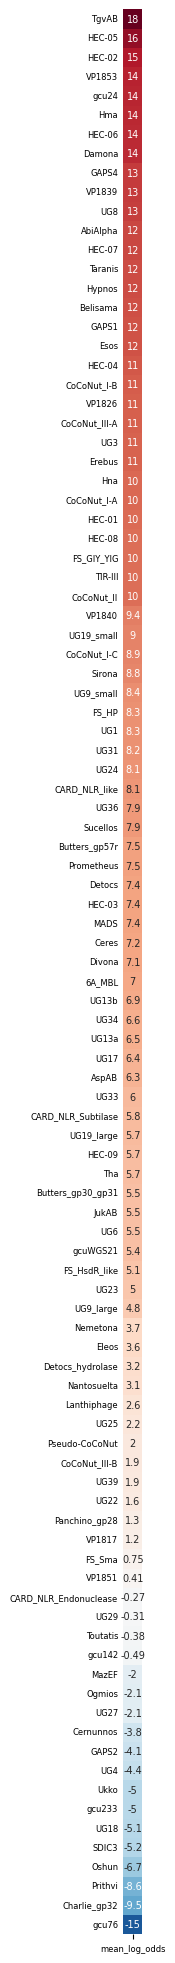

In [37]:
plt.subplots(figsize=(4, 25))
ax = sns.heatmap(top_sys_predictions.set_index('subtype_2o')[['mean_log_odds']], 
            cmap='RdBu_r', center=0, square=True, annot=True, cbar=False)
ax.tick_params(axis='y', length=0)
plt.ylabel('')
plt.savefig('../figures/dp_df_2o_sys.svg', dpi=300, bbox_inches='tight')

In [36]:
v0_top_df2o_novel = pd.read_parquet('../data3/interim/dpv0_dfv2_gene_preds.pq')
v0_top_sys_predictions = pd.read_parquet('../data3/interim/dpv0_dfv2_sys_preds.pq')

In [37]:
merged_top_df2o_novel = (top_df2o_novel.merge(v0_top_df2o_novel[['log_odds', 'defense_system_gene_2o']], 
                                              how='inner', on='defense_system_gene_2o'))

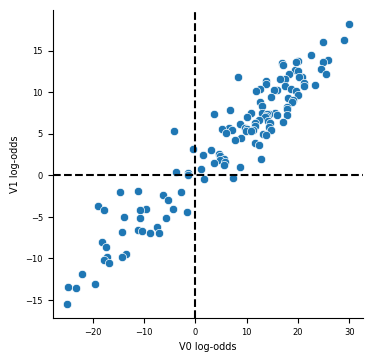

In [38]:
plt.subplots(figsize=(4,4))
sns.scatterplot(data=merged_top_df2o_novel, x='log_odds', y='mean_log_odds')
sns.despine()
plt.xlabel('V0 log-odds')
plt.ylabel('V1 log-odds')
plt.axvline(x=0, linestyle='dashed', color='black')
plt.axhline(y=0, linestyle='dashed', color='black')

In [39]:
merged_top_df2o_novel[(merged_top_df2o_novel['mean_log_odds'] > 0) & 
                      (merged_top_df2o_novel['log_odds'] < 0)]

,protein_context_id,mean_log_odds,sd_log_odds,min_log_odds,max_log_odds,# feature,class,assembly,assembly_unit,seq_type,...,defense_system_gene,defense_system,defense_system_protein,seq,seq_id,cluster_id,defense_system_gene_2o,type_2o,subtype_2o,log_odds
70,WP_070612331.1|NZ_CP081916.1|5747170|+,5.274638,1.104867,4.475363,7.462101,CDS,with_protein,GCF_020091505.1,Primary Assembly,chromosome,...,None,None,False,MLKILLVEDYEEKAKNIKIFLNTEFPFMDVEWRTSYNSAQEEIYDN...,5f1c67b5b6cc35552c565d8674f1c5a6bd027bbc21c9c4...,6fcff72df1fd76d8c0023cf07b47ab1f327200e8f570a7...,Detocs__dtcB,Detocs,Detocs,-4.054846
78,WP_131414265.1|NZ_SJXE01000001.1|665215|+,3.177606,1.835136,0.620257,5.863390,CDS,with_protein,GCF_004336975.1,Primary Assembly,unplaced scaffold,...,None,None,False,MGRYLIVEDDDAKYESINRALVEIGIRKEDVEHAPTVNAATILLRS...,84175cff585889ccde7750c5a2b0ad86f334bbd333590f...,38ceb3933cb30ff5ea20d4276092b999a0770b57d0c79b...,Detocs__dtcC_hydrolase,Detocs,Detocs_hydrolase,-0.441223
91,WP_239527548.1|NZ_JAFBBV010000001.1|422214|-,0.410276,1.961085,-3.146648,2.290516,CDS,with_protein,GCF_016907365.1,Primary Assembly,unplaced scaffold,...,None,None,False,MRIPEAVTTNYDHLYEEAVAASSGLPVGRRDLAISTLPWDPTKASR...,ea76344acbaf67acc0a2b1da1e1f1cc3fe292d12fab00f...,ea76344acbaf67acc0a2b1da1e1f1cc3fe292d12fab00f...,VP1851__VP1851,VP1851,VP1851,-3.812071
92,WP_204031374.1|NZ_BOOW01000044.1|37385|-,0.282600,0.553431,-0.386165,0.875669,CDS,with_protein,GCF_016863435.1,Primary Assembly,unplaced scaffold,...,None,None,False,MKASDHQPWLQIDVDFADPSTAEHNTIVYLVPALRSAEESGLISSW...,982b9493eb1567b671f019ebc904989d1e0c4ce1b1ec84...,5ae833a2272ad50d74a2780c24ef75975efdca488332fc...,Lanthiphage__LphD,Lanthiphage,Lanthiphage,-1.468046


In [40]:
merged_top_sys = (top_sys_predictions.merge(v0_top_sys_predictions[['log_odds', 'subtype_2o']], 
                                              how='inner', on='subtype_2o'))

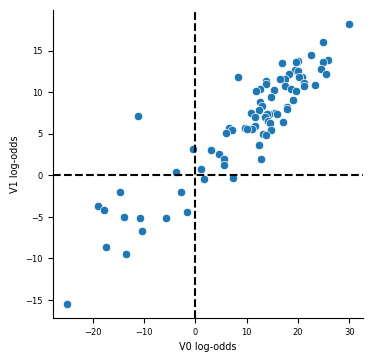

In [41]:
plt.subplots(figsize=(4,4))
sns.scatterplot(data=merged_top_sys, x='log_odds', y='mean_log_odds')
sns.despine()
plt.xlabel('V0 log-odds')
plt.ylabel('V1 log-odds')
plt.axvline(x=0, linestyle='dashed', color='black')
plt.axhline(y=0, linestyle='dashed', color='black')

In [42]:
merged_top_sys[(merged_top_sys['mean_log_odds'] > 0) & 
               (merged_top_sys['log_odds'] < 0)]

,protein_context_id,mean_log_odds,sd_log_odds,min_log_odds,max_log_odds,# feature,class,assembly,assembly_unit,seq_type,...,defense_system_gene,defense_system,defense_system_protein,seq,seq_id,cluster_id,defense_system_gene_2o,type_2o,subtype_2o,log_odds
41,WP_089404242.1|NZ_FZOH01000004.1|224573|+,7.167046,0.964446,6.026167,8.689207,CDS,with_protein,GCF_900188205.1,Primary Assembly,unplaced scaffold,...,None,None,False,MALPTCPVCDSGDLDGVEKLPDGRLVVRCLACDHEWVRGEALVPAK...,b675bf14d09b69aae0fdefbda2d8502cdbfffedfbd7c43...,44072f4fb38d9f26261ea9f7e0a813785bb977d0925502...,Ceres__CrsA2,Ceres,Ceres,-11.225807
58,WP_131414265.1|NZ_SJXE01000001.1|665215|+,3.177606,1.835136,0.620257,5.863390,CDS,with_protein,GCF_004336975.1,Primary Assembly,unplaced scaffold,...,None,None,False,MGRYLIVEDDDAKYESINRALVEIGIRKEDVEHAPTVNAATILLRS...,84175cff585889ccde7750c5a2b0ad86f334bbd333590f...,38ceb3933cb30ff5ea20d4276092b999a0770b57d0c79b...,Detocs__dtcC_hydrolase,Detocs,Detocs_hydrolase,-0.441223
65,WP_239527548.1|NZ_JAFBBV010000001.1|422214|-,0.410276,1.961085,-3.146648,2.290516,CDS,with_protein,GCF_016907365.1,Primary Assembly,unplaced scaffold,...,None,None,False,MRIPEAVTTNYDHLYEEAVAASSGLPVGRRDLAISTLPWDPTKASR...,ea76344acbaf67acc0a2b1da1e1f1cc3fe292d12fab00f...,ea76344acbaf67acc0a2b1da1e1f1cc3fe292d12fab00f...,VP1851__VP1851,VP1851,VP1851,-3.812071
